# This notebook loads trajectories of a Kerr system in the qubit regime and applies machine learning algorithms to learn about the manifold the trajectory spans.

# Please compare to the notebook Diffusion_maps_kerr_qubit, which uses quantum jumps instead of quantum state diffusion for the trajectories.

In [84]:
import sys
sys.version

'2.7.12 |Anaconda 2.4.1 (x86_64)| (default, Jun 29 2016, 11:09:23) \n[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]'

In [85]:
Regime = "kerr_qubit" ## used to load appropraite file

#  loading trajectory and using manifold my diffusion map script.

In [86]:
## load trajectory data from file
import pickle

## diffusion maps
from diffusion_maps import run_diffusion_map

## numerical
import numpy as np

## plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

In [87]:
def show_colorbar(x_index, name):
    ## show color scheme
    # http://matplotlib.org/examples/color/colormaps_reference.html

    gradient = np.linspace(0, 1, x_index)
    gradient = np.vstack((gradient, gradient))

    fig, axes = plt.subplots(figsize=(24,2))
    axes.set_title( ' colormaps', fontsize=14)
    axes.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))

    plt.show()

In [88]:
def colored_3d_plot(data_ltsa_):
    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data_ltsa_] for i in xrange(0,3)]

    x_index = len(np.asarray(to_plot_).T)/Ntraj

    color_list = np.concatenate([np.linspace(0, 1, x_index)] * Ntraj)
    colors = cm.jet(color_list)
    ax.scatter(*to_plot_,c=colors)

    show_colorbar(x_index,'jet')

In [168]:
def plot_by_operator(data,traj1,operator = "photon_num"):
    
    if operator == "photon_num":
        num = np.asmatrix(np.diag([i for i in range(Nfock)]*2))
        num_expects = np.asarray([(i*num*i.T)[0,0] for i in np.asmatrix(traj1)])
    else:
        raise ValueError("operator type not implemented")
       
    ## sort data by expected photon number
    num_expects_indices = [(i,n) for i,n in enumerate(num_expects)]
    sorted_num_expects = sorted(num_expects_indices, key = lambda z: z[1])
    data_by_num = [data[i[0]] for i in sorted_num_expects]

    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data_by_num] for i in xrange(0,3)]

    ## color bar
    x_index = len(np.asarray(to_plot_).T)
    color_list = np.concatenate([np.linspace(0, 1, x_index)] )
    colors = cm.jet(color_list)
    ax.scatter(*np.asarray(to_plot_),c=colors)
    show_colorbar(x_index,'jet')

## Diffusion maps

In [89]:
## load trajectory data from file

pkl_file = open('../SDEs/trajectory_data/QSD_'+ Regime +'.pkl', 'rb')
pkl_dict = pickle.load(pkl_file)
pkl_file.close()

In [90]:
## pre-process expectation values

traj_expects = np.concatenate(pkl_dict['expects']).real.T

In [91]:
Ntraj,duration,Nfock = pkl_dict['psis'].shape

In [92]:
Ntraj,duration,Nfock

(10, 7500, 15)

In [93]:
# ##  Extract data into points of format (psi.real,psi.imag) from all trajectories.

# traj_data = np.concatenate(
#             [[ np.concatenate([f(pkl_dict['psis'][traj_num][time_num]) 
#                 for f in (lambda x: x.real, lambda x: x.imag) ]) 
#                     for traj_num in range(Ntraj)]
#                         for time_num in range(int(duration))])

In [140]:
##  Extract data into points of format (psi.real,psi.imag) from all trajectories.

traj_data = np.concatenate(
            [[ np.concatenate([f(pkl_dict['psis'][traj_num][time_num]) 
                for f in (lambda x: x.real, lambda x: x.imag) ]) 
                    for traj_num in range(Ntraj)]
                        for time_num in range(1000,6000)])

In [155]:
## sample 
traj1 = traj_data[1::40]

In [156]:
traj1.shape

(1667, 30)

In [176]:
## Paramters to use

diffusion_params = {}

diffusion_params["gaussian_epsilon"] = 0.3 ## width of Gaussian kernel.
diffusion_params["num_neighbors"] = 300 ## cutoff of number of neighbors, if using epsilon_cutoff
diffusion_params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

diffusion_params["data_size"] = 1000 ## total number of points
diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

In [177]:
## Using the euclidean (default) metric

e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                   diffusion_params,
                                   symmetric=True,
                                   neighbor_selection = "num_neighbors")


using num_neighbors  


In [178]:
# colored_3d_plot(e_vecs.T[1:].T)

## The shape above resembles the Hopf fibration. This can be explained if the states with the global phase removed lie on a circle on the Bloch sphere. See http://nilesjohnson.net/hopf.html

## Next, let's color the same plot by the photon number.

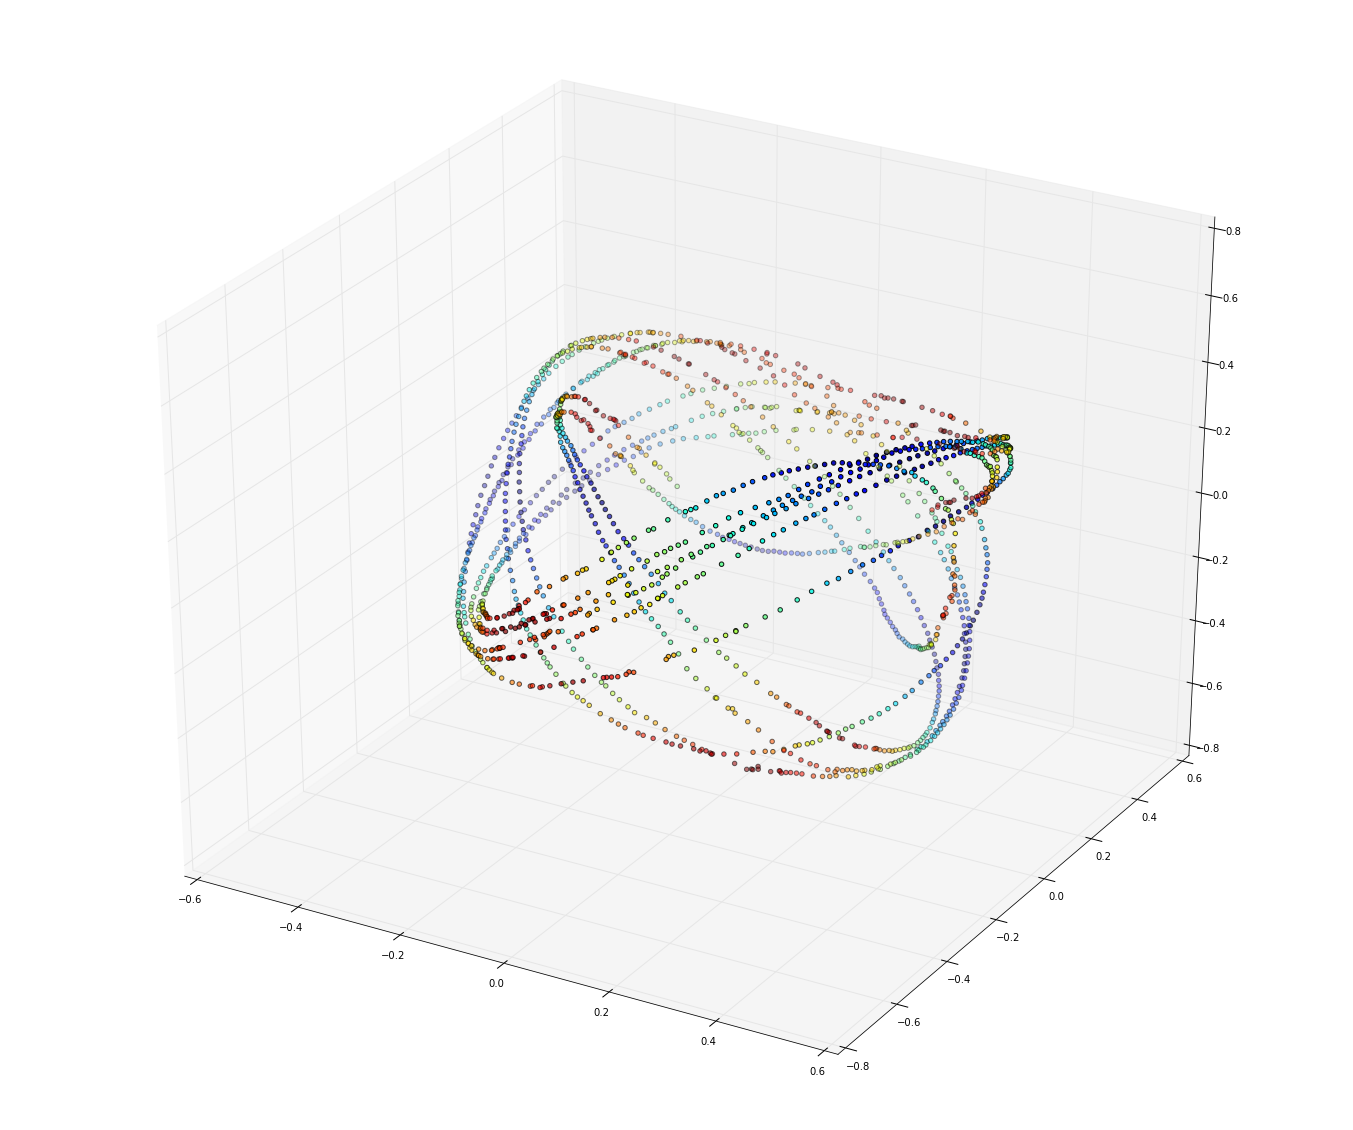

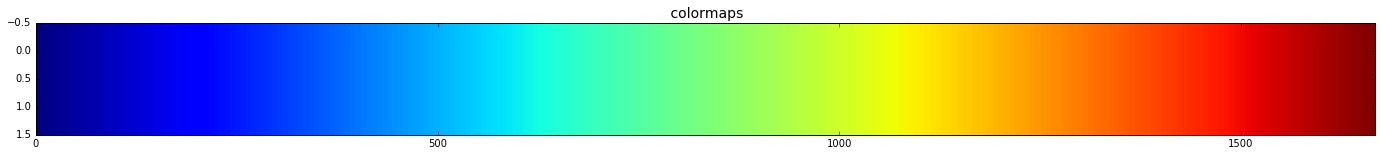

In [179]:
plot_by_operator(e_vecs.T[1:].T,traj1)

# Fubini-Study metric below!

In [180]:
## Using the euclidean (default) metric
diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                   diffusion_params,
                                   symmetric=True,
                                   metric = "FS_metric",
                                   neighbor_selection = "num_neighbors")

using num_neighbors  


## Color by photon number

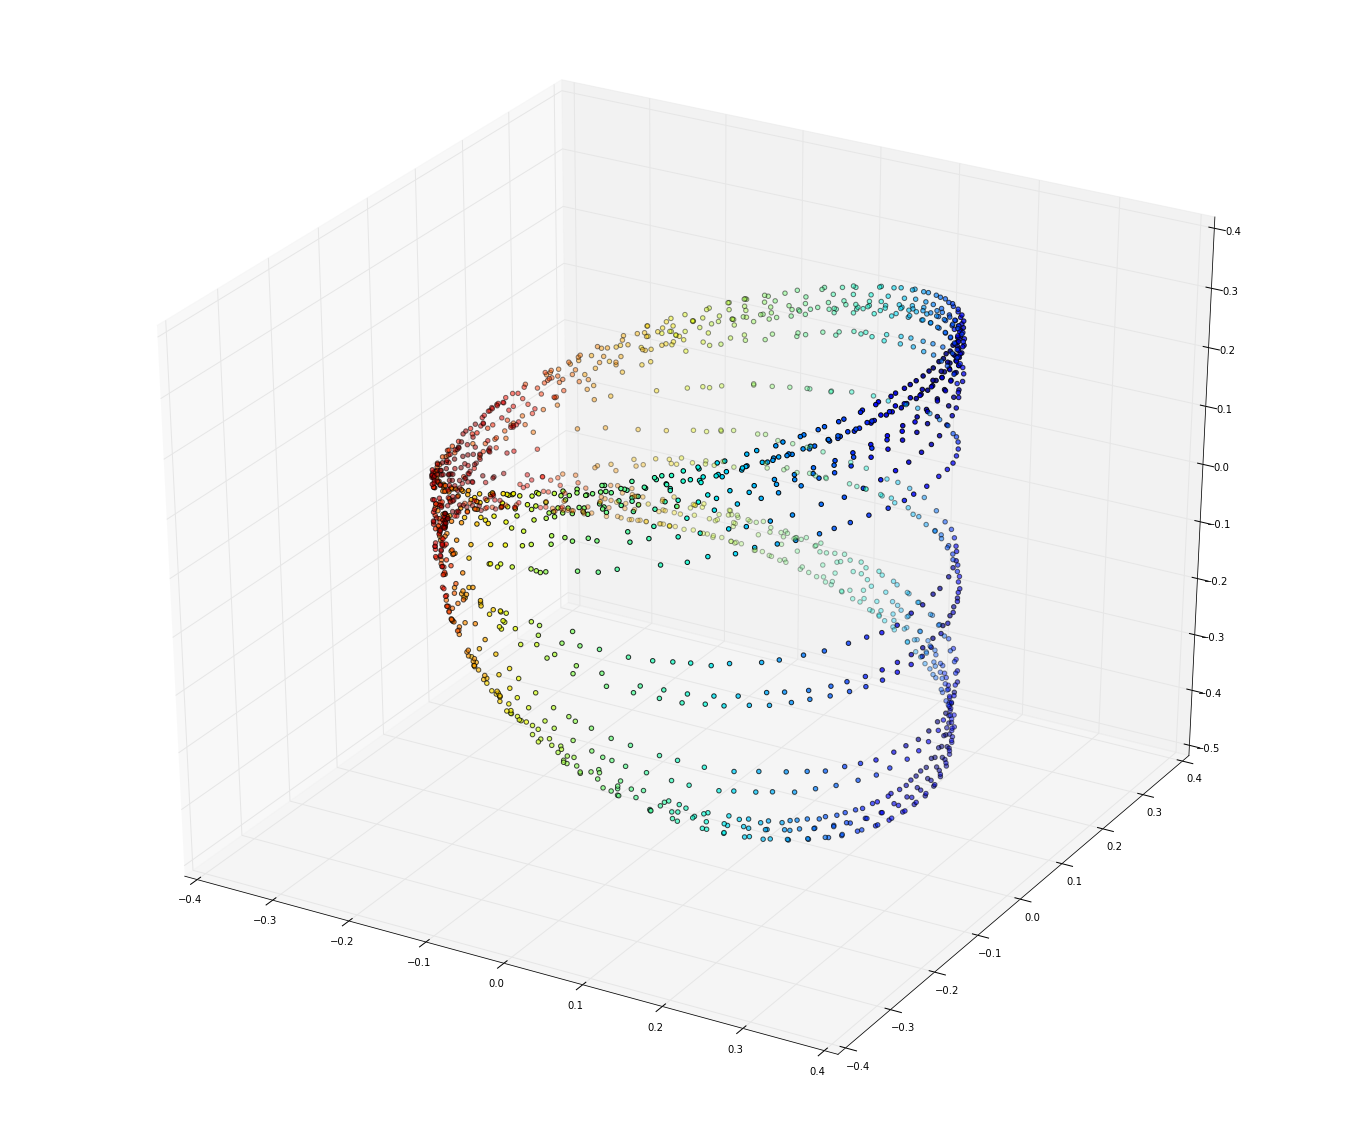

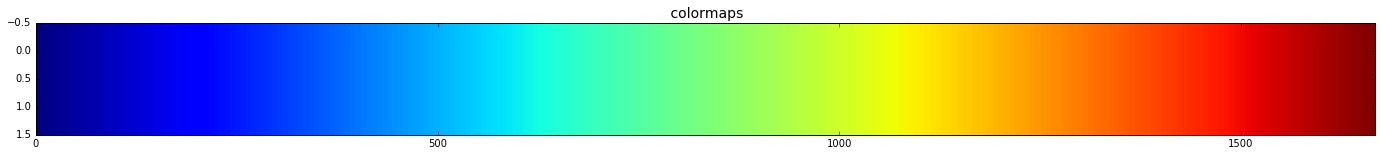

In [181]:
plot_by_operator(e_vecs.T[1:].T,traj1)